In [16]:
import tesserocr
from PIL import Image
import numpy as np

image = Image.open('captcha2.png')
image = image.convert('L')
threshold  = 100
array = np.array(image)
array = np.where(array > threshold ,255, 0)

image = Image.fromarray(array.astype('uint8'))
image.show()
print(tesserocr.image_to_text(image))

a b 3 c



In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from io import BytesIO
import numpy as np
from PIL import Image
import tesserocr
import re
import time

from retrying import retry
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

LOGIN_URL = 'https://captcha7.scrape.center/'
ACCOUTN = 'admin'
PASSWORD = 'admin'
THRESHOLD = 150

def preprocess(image):
    image = image.convert('L')
    array = np.array(image)
    array = np.where(array > THRESHOLD, 255, 0)
    image = Image.fromarray(array.astype('uint8'))
    return image

@retry(stop_max_attempt_number=10, retry_on_result=lambda x:x is False)
def login():
    # browser = webdriver.Chrome()
    browser.get(LOGIN_URL)

    ### 这里应该加一个等待
    # 填入账号和密码
    browser.find_element(By.CSS_SELECTOR, '.username input[type="text"]').send_keys(ACCOUTN)
    time.sleep(1)
    browser.find_element(By.CSS_SELECTOR, '.password input[type="password"]').send_keys(PASSWORD)
    time.sleep(1)

    # 验证码图片识别
    captcha = browser.find_element(By.CSS_SELECTOR, '#captcha')
    image = Image.open(BytesIO(captcha.screenshot_as_png))
    print(type(captcha.screenshot_as_png))
    image = preprocess(image)
    captcha = tesserocr.image_to_text(image)
    captcha = re.sub('[^A-Za-z0-9]', '', captcha)

    # 填入验证码
    browser.find_element(By.CSS_SELECTOR, '.captcha input').send_keys(captcha)
    time.sleep(1)

    # 点击登录按钮
    # browser.find_element(By.CSS_SELECTOR, 'button[type="button"]').click()
    browser.find_element(By.CSS_SELECTOR, '.login').click()

    # 判断是否登录成功
    try:
        WebDriverWait(browser, 5).until(EC.presence_of_element_located((By.XPATH, '//h2[contains(., "登录成功")]')))
        time.sleep(5)
        browser.close()
        return True
    except TimeoutException:
        return False

if __name__ == "__main__":
    browser = webdriver.Chrome()
    login()

<class 'bytes'>


# 果核剥壳

草稿

```Python
captcha = browser.find_element(By.CSS_SELECTOR, '#captcha')
image = Image.open(BytesIO(captcha.screenshot_as_png))
image = preprocess(image)
captcha = tesserocr.image_to_text(image)
captcha = re.sub('[^A-Za-z0-9]', '', captcha)
```

### 通过 获取网页源代码中验证码图片的 `src` 链接获取图片

In [27]:
import numpy as np
import requests
from PIL import Image
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

browser = webdriver.Chrome()

browser.get('https://www.ghxi.com/login')

browser.find_element(By.CSS_SELECTOR, '.captcha-button').click()
time.sleep(2)
browser.switch_to.frame('tcaptcha_iframe')
image_src = browser.find_element(By.CSS_SELECTOR, '#slideBg').get_attribute('src')
image_src

'https://t.captcha.qq.com/hycdn?index=1&image=937404024411908608?aid=2058282041&sess=s0hG3NNN8naKED4Nzdh_qowMORXiQvJ7fQGW5JgovCtpsca8zFvmCDV7Dbm7aegwCWsm6RltEwwk61IT5SpJBUEuuCq01yf4WXTm4E4gkskPbIpWzoEkuWVKIs-4P3rD7QOb5FoyUFm5kYlpsorPiHRmE-Fq2-2VpCR1GGj9tXe_IQsZZwTQG3x5OSIUK6Fz1z6obFbCKWnfSG0b8zj5qDYkDo-ajFX3j_mIOIcMbhVrD0UWSoWl8zeazz_9Nud6gvbtsy1NshTEIOcoYfkkrG8AipEnFMlTgM5PMtoPttfjg*&sid=6957669013621477376&img_index=1&subsid=3'

(680, 390)


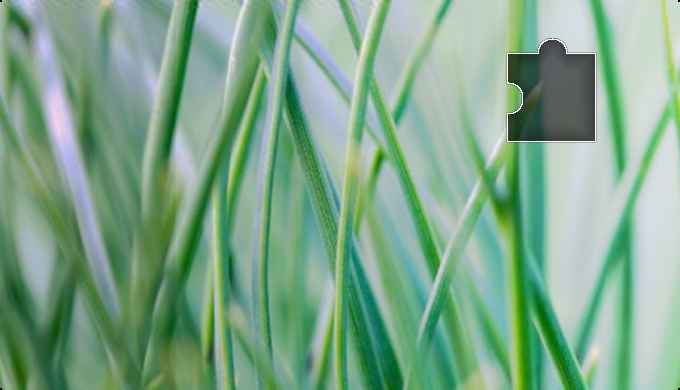

In [30]:
image = requests.get(image_src).content
image = Image.open(BytesIO(image))
print(np.size(image))
image

### 通过 **`selenium`** 的截图功能获取图片

In [43]:
import numpy as np
import requests
from PIL import Image
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

browser = webdriver.Chrome()

browser.get('https://www.ghxi.com/login')

browser.find_element(By.CSS_SELECTOR, '.captcha-button').click()
time.sleep(2)
browser.switch_to.frame('tcaptcha_iframe')

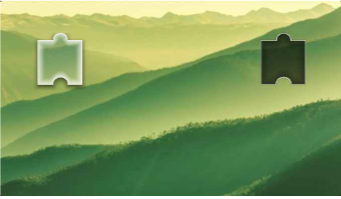

In [44]:
slideBgWrap = browser.find_element(By.CSS_SELECTOR, '#slideBgWrap')
slideBgWrap = Image.open(BytesIO(slideBgWrap.screenshot_as_png))
slideBgWrap

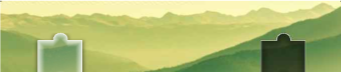

In [45]:
slideBlockWrap = browser.find_element(By.CSS_SELECTOR, '#slideBlockWrap')
slideBlockWrap = Image.open(BytesIO(slideBlockWrap.screenshot_as_png))
slideBlockWrap

## 图片处理

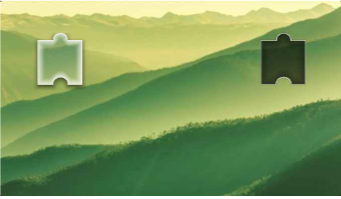

In [50]:
slideBgWrap

(285, 293, 13, 27)
(306, 255, 41, 50)
(210, 250, 25, 15)
(236, 236, 25, 15)
(251, 240, 3, 3)
(316, 202, 8, 6)
(325, 194, 57, 51)
(163, 53, 84, 94)
(163, 53, 84, 94)
(11, 53, 84, 95)
(11, 53, 84, 95)


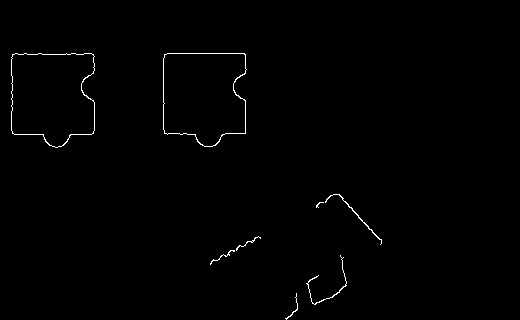

In [75]:
import cv2
GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450

image_raw = cv2.imread('captcha3.png')
# 高斯滤波
image = cv2.GaussianBlur(image_raw, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)

# 边缘检测
image = cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

# 轮廓提取
contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in contours:
    print(cv2.boundingRect(i))

# x, y, w, h

array = np.array(image)
show = Image.fromarray(array.astype('uint8'))
show

所以，我们需要先确定怎么来筛选，比如面积我们可以设定一个范围，周长设定一个范围，缺口位置设定一个范围，通过实际测量，我们可以得出:

目标缺口的

外接矩形的高度大约是验证码高度的 0.25 倍，
宽度大约是验证码宽度的 0.15 倍。在允许误差 20% 的情况下，根据验证码的宽高信息我们大约可以计算出面积、周长的范围，同时缺口位置（缺口左侧）也有一个最小偏移值，比如最小偏移是验证码宽度的 0.2 倍，最大偏移是验证码宽度的 0.85 倍。综合这些内容，我们可以定义三个阈值方法：

In [ ]:
import cv2

GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450

# 高斯滤波
def get_gaussian_blur_image(image):
    return cv2.GaussianBlur(image, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)

# 边缘检测
def get_canny_image(image):
    return cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

# 轮廓提取
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    return contours


# 缺口面积范围（20%误差）
def get_contour_area_threshold(image_width, image_height):
    contour_area_min = (image_width * 0.15) * (image_height * 0.25) * 0.8
    contour_area_max = (image_width * 0.15) * (image_height * 0.25) * 1.2
    return contour_area_min, contour_area_max

# 缺口周长范围（20%误差）
def get_arc_length_threshold(image_width, image_height):
    arc_length_min = ((image_width * 0.15) + (image_height * 0.25)) * 2 * 0.8
    arc_length_max = ((image_width * 0.15) + (image_height * 0.25)) * 2 * 1.2
    return arc_length_min, arc_length_max

# 最小偏移与最大偏移？？？
def get_offset_threshold(image_width):
    offset_min = 0.2  * image_width     # 缺口位置 最小偏移是验证码宽度的 0.2 倍
    offset_max = 0.85 * image_width     # 缺口位置 最大偏移是验证码宽度的 0.85 倍
    return offset_min, offset_max


def main():
    image_raw = cv2.imread('captcha3.png')                      # 读取验证码图片文件
    image_height, image_width, _ = image_raw.shape              # 验证码图片的尺寸（高度、宽度、）

    image_gaussian_blur = get_gaussian_blur_image(image_raw)    # 高斯滤波
    image_canny = get_canny_image(image_gaussian_blur)          # 边缘检测
    contours = get_contours(image_canny)                        # 轮廓提取 验证码中所有的轮廓

    ### 图片存储
    cv2.imwrite('image_gaussian_blur.png', image_gaussian_blur) # 高斯滤波（模糊）
    cv2.imwrite('image_canny.png', image_canny)                 # 边缘检测

    ### 目标轮廓 面积、周长、偏移
    contour_area_min, contour_area_max = get_contour_area_threshold(image_width, image_height)
    arc_length_min,   arc_length_max   = get_arc_length_threshold(image_width, image_height)
    offset_min,       offset_max       = get_offset_threshold(image_width)
    offset = None

    ### 筛选出符合条件的轮廓 即为 验证码缺口轮廓
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)      # 轮廓的外界矩形
        '''
            cv2.contourArea(contour)    # 轮廓的面积
            cv2.arcLength(contour)      # 轮廓的周长
        '''
        if contour_area_min < cv2.contourArea(contour)     < contour_area_max and \
            arc_length_min  < cv2.arcLength(contour, True) < arc_length_max and \
            offset_min      < x                            < offset_max:
            cv2.rectangle(image_raw, (x, y), (x + w, y + h), (0, 0, 255), 2)
            offset = x
    cv2.imwrite('image_label.png', image_raw)
    print('offset', offset)

if __name__ == '__main__':
    main()

offset 163
